In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "data/audio/"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

aurevoir
bas
bonjour
droite
gauche
haut
non
oui



In [2]:
#Import stuff

import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

%matplotlib inline

In [3]:
def load_audio_file(file_path):
    input_length = 16000
    data = librosa.core.load(file_path)[0]
    return data
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

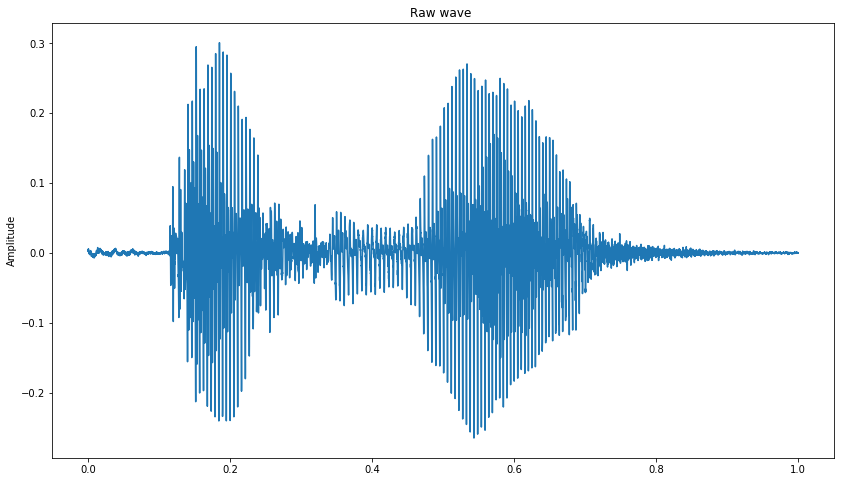

In [4]:
data = load_audio_file("data/audio/aurevoir/aurevoir_mathilde_01.wav")
plot_time_series(data)

In [5]:
#Hear it ! 
ipd.Audio(data, rate=22050)

alpha=0.250, k=0.250, p=1.250


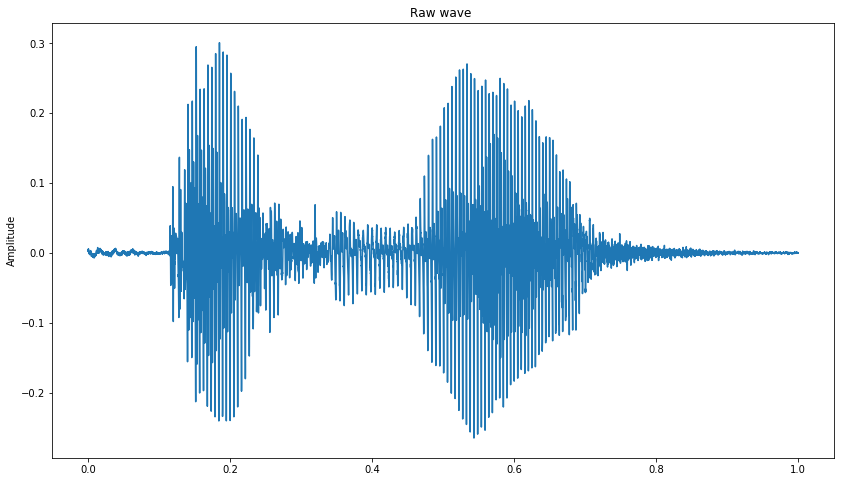

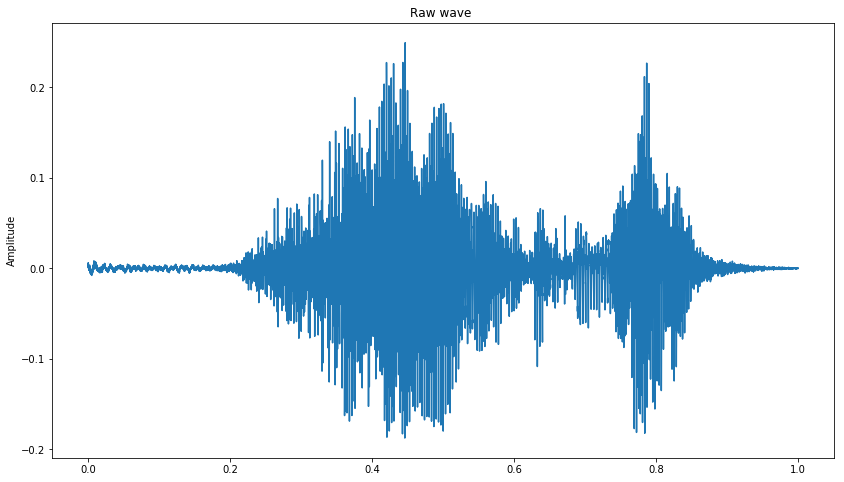

In [6]:
alpha = 0.25
k = 0.25
p = (1-k*alpha)/(1-alpha)
y1 = np.concatenate([
    librosa.effects.time_stretch(data[0:int(len(data)*alpha)],k),
    librosa.effects.time_stretch(data[int(len(data)*alpha):],p)
])
print("alpha=%.3f, k=%.3f, p=%.3f" % (alpha, k, p))
plot_time_series(data)
plot_time_series(y1)
ipd.Audio(y1, rate=22050)

In [7]:
G = lambda x: -x*(x-0.1)*(x-0.2)*(x-0.4)*(x-0.6)*(x-0.8)*(x-0.9)*(x-1.0)

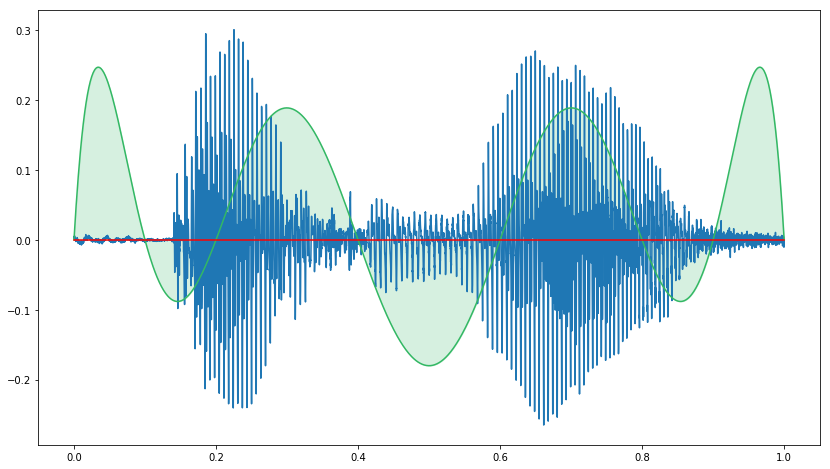

In [8]:
scale = 5000
plt.figure(figsize=(14, 8))
plt.plot(np.linspace(0,1,16000),data[:16000])
xs = np.linspace(0,1,1000)
plt.plot(xs,G(xs)*scale, color="xkcd:cool green")
plt.plot(xs,np.zeros(len(xs)), "r")
plt.fill_between(xs,G(xs)*scale,color=to_rgba("xkcd:cool green",0.2))

In [9]:
stretch_coef = lambda G,n,amp: lambda j: (n*(G((j+1)/n)-G(j/n))-G(1)+G(0))*amp

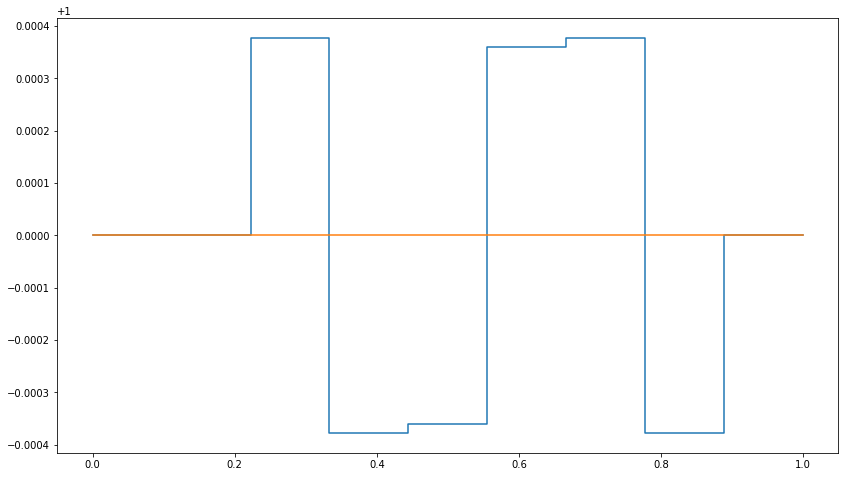

In [10]:
n = 10
amplifier = 1
p = lambda i: 1+stretch_coef(G,n,amplifier)(i)
plt.figure(figsize=(14, 8))
xs = np.linspace(0,1,n)
ys = np.array(list(map(p, range(n))))
plt.step(xs, ys, where="post")
plt.plot(xs, np.zeros(n)+1)

In [11]:
def stretch(y,G,n,amplifier):
    spl = np.array_split(y, n)
    p = lambda i: 1+stretch_coef(G,n,amplifier)(i)
    res = [
        librosa.effects.time_stretch(spl[i],p(i))
        for i in range(n)
    ]
    print([len(x) for x in res])
    return np.concatenate(res)

19472
[1536, 1536, 1536, 2048, 2048, 1536, 1536, 2048, 1536, 1536]
16896
[2048, 2048, 2048, 2048, 2048, 2048, 1536, 1536, 1536, 1536]
18432


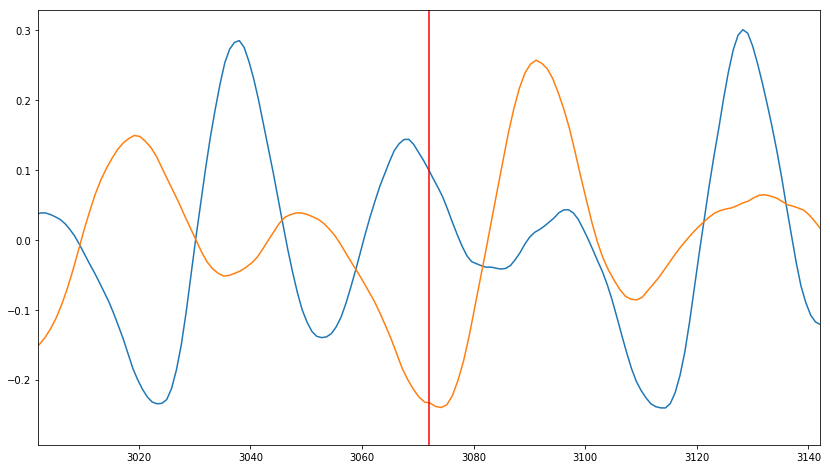

In [12]:
#ici on voit les "chirps"
G1 = lambda x: -np.sin(x)

n = 10

print(len(data))
y1 = stretch(data,G,n,1)
print(len(y1))
y2 = stretch(data,G1,n,1)
print(len(y2))

plt.figure(figsize=(14, 8))
plt.plot(np.linspace(0,len(y1),len(data)),data)
#plt.plot(np.linspace(0,1,len(y2)),y2)
plt.plot(np.linspace(0,len(y1),len(y1)),y1)
#plt.plot(np.linspace(0,1,len(y2)),y2)

delta = 70
for i in np.cumsum([1536, 1536, 1536, 2048, 2048, 1536, 1536, 2048, 1536, 1536]):
    plt.axvline(x=i,color="red")
x0 = 1536*2
plt.xlim(x0-delta, x0+delta)

ipd.Audio(y1, rate=22050)

In [13]:
def time_transform(y, G, n, amplifier, visualize=False, sr=22050, cscale = 8000, dscale = 500):
    """Transform the time with 1+G'(x) stretch coefficients
    
    input:
        y:         the input signal 
        G:         integral of the transformation function 
                    (must be differentiable)
        n:         number of intervals for discretization
        amplifier: time distortion intensity amplifier
        visualize: Original/Transformation/Remix graphs 
                    and Original/Remix audio widgets
        sr:        sample rate
        cscale:    G(x) plot scale
        dscale:    discretized G'(x) plot scale

    output:
        the remixed sequence
    """
    stretch_coef = lambda G,n,amp: lambda j: (n*(G((j+1)/n)-G(j/n))-G(1)+G(0))*amp
    p = lambda i: 1+stretch_coef(G,n,amplifier)(i)
    
    if visualize:
        ys = np.array(list(map(p, range(n))))
        plt.figure(figsize=(14, 4))
        ax = plt.subplot(1, 3, 1)
        ax.set_title("Original")
        xs = np.linspace(0,len(y),len(y))
        plt.plot(xs,y)
        for i in range(n+1):
            plt.axvline(x=i/n*len(y),color=to_rgba("red",0.2))
        ax = plt.subplot(1, 3, 2)
        ax.set_title("Transformation")
    
        plt.plot(xs,y,color=to_rgba("blue",0.2))
        plt.plot(xs,G(xs/len(y))*scale, color="xkcd:cool green")
        plt.plot(xs,np.zeros(len(xs)), "r")
        plt.fill_between(xs,G(xs/len(y))*scale,color=to_rgba("xkcd:cool green",0.2))
        plt.step(np.arange(n)/n*len(y), (ys-1)*dscale, where="post", color="red")
        for i in range(n+1):
            plt.axvline(x=i/n*len(y),color=to_rgba("red",0.2))
            
    spl = np.array_split(y, n)
    res = [
        librosa.effects.time_stretch(spl[i],p(i))
        for i in range(n)
    ]
    y1 = np.concatenate(res)
    
    if visualize:
        ax = plt.subplot(1, 3, 3)
        ax.set_title("Remix")
        plt.plot(xs,y,color=to_rgba("blue",0.8))
        xs = np.linspace(0,len(y),len(y1))
        plt.plot(xs,y1,color=to_rgba("red",0.6))
        lens = [len(x) for x in res]
        for i in np.concatenate([np.array([0]),np.cumsum(lens)]):
            plt.axvline(x=i,color=to_rgba("red",0.2))
    
        print("Original audio:")
        ipd.display(ipd.Audio(y, rate=sr))
        print("Remixed audio:")
        ipd.display(ipd.Audio(y1, rate=sr))
    
    # scale back in case something went wrong
    
    return librosa.effects.time_stretch(y1, len(y1)/len(y))

Original audio:


Remixed audio:


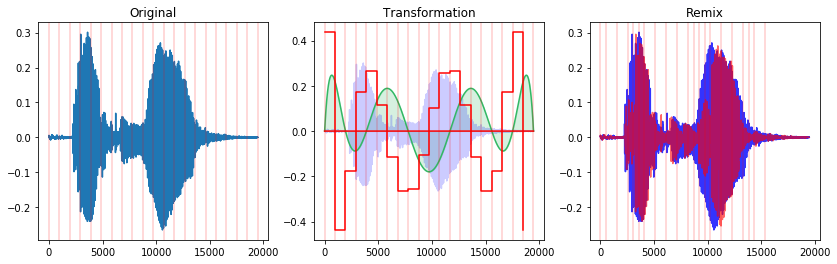

In [14]:
mixed = time_transform(data, G, 20, 1, visualize=True)
librosa.output.write_wav("test.wav", mixed, 22050, norm=True)

In [15]:
mixed = load_audio_file("test.wav")
mix_edited = load_audio_file("test1.wav")

[Repair Audacity source](https://github.com/audacity/audacity/blob/master/src/effects/Repair.cpp) - need to look here for click removal

[Resampling with SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) - or here

(5072, 5172)

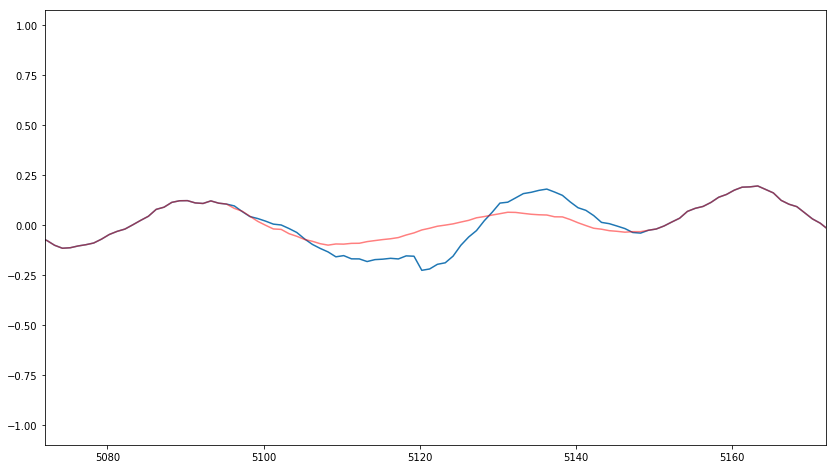

In [16]:
plt.figure(figsize=(14, 8))
xs = np.linspace(0,len(mixed),len(mixed))
plt.plot(xs,mixed)

xs = np.linspace(0,len(mix_edited),len(mix_edited))
plt.plot(xs,mix_edited, color=to_rgba("red", 0.5))
x0 = 5122
delta = 50
plt.xlim(x0-delta, x0+delta)

# Random splitting

In [17]:
def ransplit(n, v=1):
    lens = (np.random.randn(n+1)/n*v+1)/n
    cums = np.cumsum(lens)-lens[0]
    return cums / max(cums)

In [18]:
ransplit(10)

array([0.        , 0.09142153, 0.19236628, 0.28791368, 0.39112917,
       0.48567839, 0.59049207, 0.69296084, 0.81207856, 0.90527899,
       1.        ])

In [19]:
def fill_plot(xs, ys, color="xkcd:cool green", fill_opacity=0.2):
    plt.plot(xs, ys, color=color)
    plt.fill_between(xs, ys, color=to_rgba(color,fill_opacity))

def split_plot(xs, color="red", opacity=1):
    for x in xs:
        plt.axvline(x=x,color=to_rgba(color,opacity))

def poly_plot(r_or_G, color="xkcd:cool green", split_color="red"):
    if type(r_or_G)==dict:
        roots = r_or_G["roots"]
    else:
        roots = r_or_G
    xs = np.linspace(np.min(roots),np.max(roots),1000)
    plt.plot(xs, np.zeros(1000),color="black", linestyle="dashed")
    G = np.poly1d(roots,r=True)
    fill_plot(xs, G(xs), color=color)
    split_plot(roots, color=split_color, opacity=0.5)

def G_gen(n,e):
    roots = ransplit(n,e)
    return {
        "roots": roots,
        "G": np.poly1d(roots,r=True)
    }

def grid_plot(f, rows, cols, figsize=(14,6)):
    plt.figure(figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            plt.subplot(rows, cols, i*cols+j+1)
            f(i*cols+j)

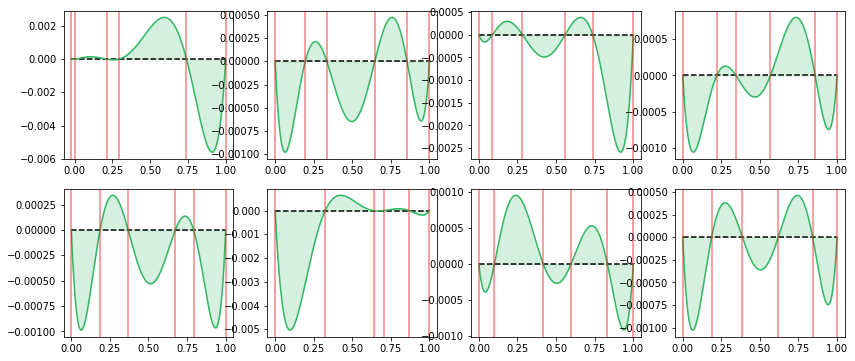

In [20]:
n = 5
e = 2

Gs = [G_gen(n,e) for x in range(8)]
grid_plot(lambda i: poly_plot(Gs[i]), 2, 4)

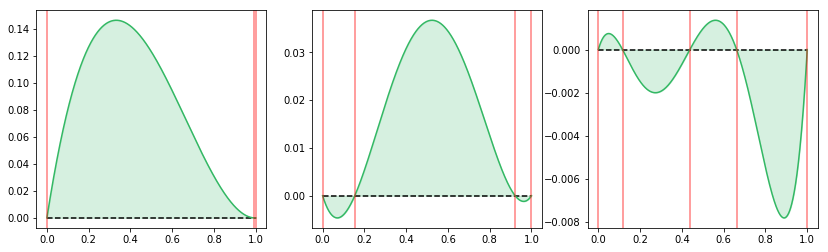

In [21]:
grid_plot(lambda i: [
    lambda: poly_plot(G_gen(2,2)),
    lambda: poly_plot(G_gen(3,2)),
    lambda: poly_plot(G_gen(4,2))
][i](), 1, 3, figsize=(14,4))

# Utilisons le formule

In [22]:
stretch_coef = lambda G,n,amp: lambda j: (n*(G((j+1)/n)-G(j/n))-G(1)+G(0))*amp

In [23]:
def p_plot(Gs, n, amplifier):
    poly_plot(Gs,split_color="xkcd:cool green")
    plt.axhline(y=0, color="black", linestyle="dashed")
    ys = np.array(list(map(stretch_coef(Gs["G"],n,amplifier), range(n))))
    plt.step((np.arange(n+2)-1)/n, np.concatenate([[0],ys,[0]])*0.25, where="post", color="red")
    plt.fill_between(
        (np.arange(n+2)-1)/n, 
        np.concatenate([[0],ys,[0]])*0.25, 
        np.zeros(n+2), 
        step="post", color=to_rgba("red",0.2))
    for i in range(n+3):
        plt.axvline(x=i/n,color=to_rgba("red",0.2))
    plt.xlim(-0.1,1.1)

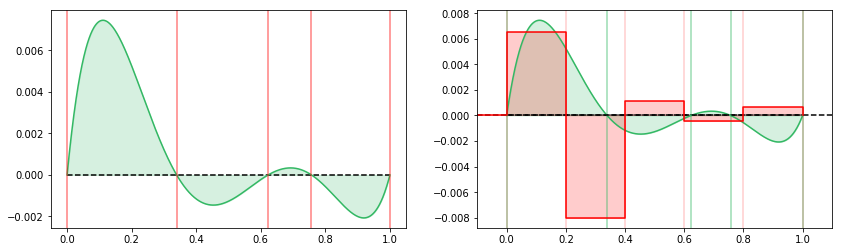

In [24]:
Gs = G_gen(4,2)
n = 5
amplifier = 1
#p = lambda i: 1+stretch_coef(Gs["G"],n,amplifier)(i)

grid_plot(lambda i: [
    lambda: poly_plot(Gs),
    lambda: p_plot(Gs, n, amplifier)
][i](), 1, 2, figsize=(14,4))

Original audio:


Remixed audio:


Original audio:


Remixed audio:


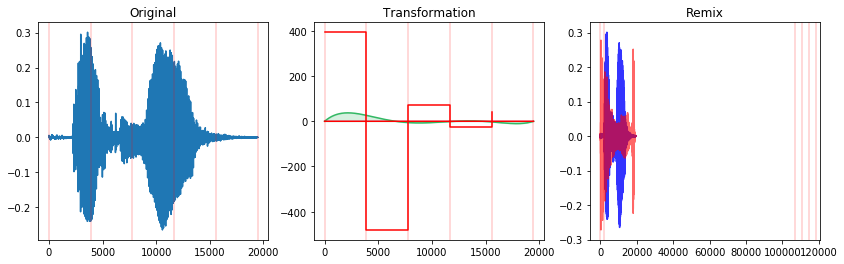

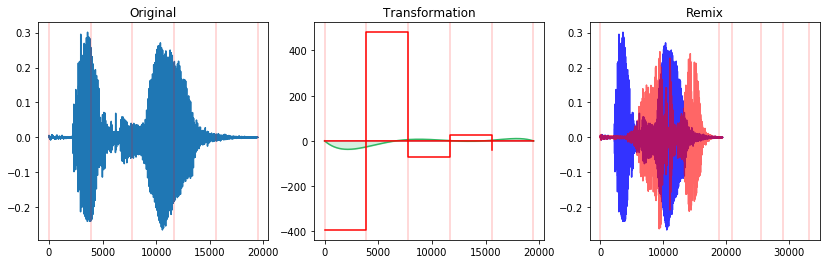

In [25]:
mixed1 = time_transform(data, Gs["G"], 5, 30, visualize=True)
mixed2 = time_transform(data, lambda x: -Gs["G"](x), 5, 30, visualize=True)

In [26]:
n = 5
amplifier = 15
Gs = [G_gen(6,3) for x in range(3)]

Generated 12 mixes. For 30 tracks this will be 360


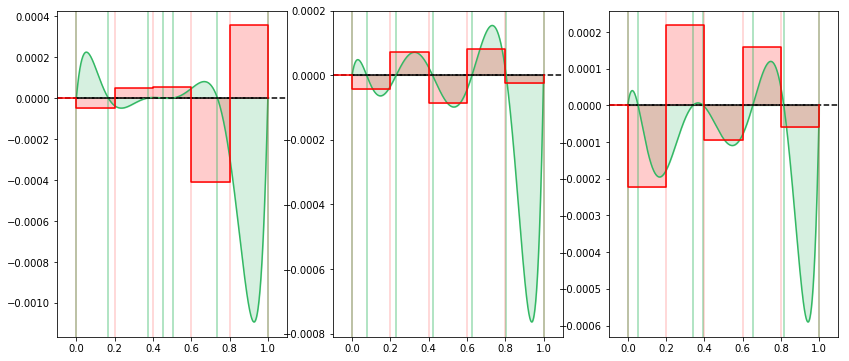

In [27]:
#si ça plante il faut relancer la cellule d'avant
grid_plot(lambda i: p_plot(Gs[i],n,1), 1, 3)

mix = lambda data, G: time_transform(data, G["G"], n, amplifier, visualize=False)
negmix = lambda data, G: time_transform(data, lambda x: -G["G"](x), n, amplifier, visualize=False)
revmix = lambda data, G: time_transform(data, lambda x: G["G"](1-x), n, amplifier, visualize=False)
negrevmix = lambda data, G: time_transform(data, lambda x: -G["G"](1-x), n, amplifier, visualize=False)

mixes = [mix(data,G) for G in Gs] + \
    [negmix(data,G) for G in Gs] + \
    [revmix(data,G) for G in Gs] + \
    [negrevmix(data,G) for G in Gs]

res = np.concatenate(mixes)
print("Generated %d mixes. For 30 tracks this will be %d" % (len(mixes), len(mixes)*30))

ipd.Audio(res,rate=22050)

In [28]:
def allmixes(data, Gs, n, amplifier):
    mix = lambda data, G: time_transform(data, G["G"], n, amplifier, visualize=False)
    negmix = lambda data, G: time_transform(data, lambda x: -G["G"](x), n, amplifier, visualize=False)
    revmix = lambda data, G: time_transform(data, lambda x: G["G"](1-x), n, amplifier, visualize=False)
    negrevmix = lambda data, G: time_transform(data, lambda x: -G["G"](1-x), n, amplifier, visualize=False)

    return [mix(data,G) for G in Gs] + \
        [negmix(data,G) for G in Gs] + \
        [revmix(data,G) for G in Gs] + \
        [negrevmix(data,G) for G in Gs]

In [29]:
labels = check_output(["ls", "data/audio/"]).decode("utf-8").split("\n")[:-1]
labels

['aurevoir', 'bas', 'bonjour', 'droite', 'gauche', 'haut', 'non', 'oui']

In [30]:
def trimClip(y):
    yt, index = librosa.effects.trim(y, top_db=11)
    return (yt)

In [31]:
for label in labels:
    print("Processing "+label+":")
    filenames = check_output(["ls", "data/audio/"+label+"/"]).decode("utf-8").split("\n")[:-1]
    for fname in filenames:
        print("> Processing "+fname[:-4]+":")
        data = trimClip(librosa.util.normalize(load_audio_file("data/audio/"+label+"/"+fname)))
        librosa.output.write_wav("mixes/"+label+"/"+fname[:-4]+"_00.wav", data, 22050, norm=True)
        mixes = allmixes(data, Gs, 5, 15)
        for i in range(len(mixes)):
            print(">> Processing mix #"+str(i+1))
            librosa.output.write_wav(
                "mixes/"+label+"/"+fname[:-4]+"_"+"{0:02d}".format(i+1)+".wav", 
                trimClip(mixes[i]), 22050, norm=True
            )

Processing aurevoir:
> Processing aurevoir_adel_01:
>> Processing mix #1
>> Processing mix #2
>> Processing mix #3
>> Processing mix #4
>> Processing mix #5
>> Processing mix #6
>> Processing mix #7
>> Processing mix #8
>> Processing mix #9
>> Processing mix #10
>> Processing mix #11
>> Processing mix #12
> Processing aurevoir_adel_02:
>> Processing mix #1
>> Processing mix #2
>> Processing mix #3
>> Processing mix #4
>> Processing mix #5
>> Processing mix #6
>> Processing mix #7
>> Processing mix #8
>> Processing mix #9
>> Processing mix #10
>> Processing mix #11
>> Processing mix #12
> Processing aurevoir_adel_03:
>> Processing mix #1
>> Processing mix #2
>> Processing mix #3
>> Processing mix #4
>> Processing mix #5
>> Processing mix #6
>> Processing mix #7
>> Processing mix #8
>> Processing mix #9
>> Processing mix #10
>> Processing mix #11
>> Processing mix #12
> Processing aurevoir_agnes_01:
>> Processing mix #1
>> Processing mix #2
>> Processing mix #3
>> Processing mix #4
>> Pr

KeyboardInterrupt: 

In [32]:
def preprocess(file):
    librosa.output.write_wav(
        file, 
        trimClip(librosa.util.normalize(load_audio_file(file))), 
        22050, 
        norm=True
    )

In [33]:
preprocess("data/test/steven_test-01.wav")
preprocess("data/test/steven_test-02.wav")
preprocess("data/test/test-01.wav")
preprocess("data/test/test-02.wav")
preprocess("data/test/test-03.wav")
preprocess("data/test/test-04.wav")

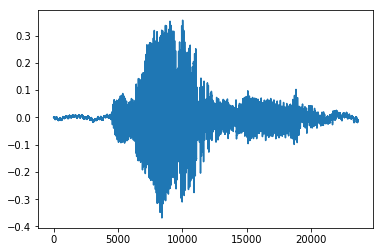

In [39]:
y = load_audio_file("test3.wav")
plt.plot(y)
ipd.Audio(y,rate=22050)

In [36]:
Gs

[{'G': poly1d([ 1.        , -3.23109914,  4.13660385, -2.68018927,  0.92285037,
         -0.15857012,  0.01040432,  0.        ]),
  'roots': array([0.        , 0.16668231, 0.37277932, 0.45121034, 0.50375333,
         0.73667385, 1.        ])},
 {'G': poly1d([ 1.00000000e+00, -3.15736950e+00,  3.84697365e+00, -2.27218861e+00,
          6.66752526e-01, -8.78694509e-02,  3.70138925e-03,  0.00000000e+00]),
  'roots': array([0.        , 0.07587645, 0.23035805, 0.42018683, 0.62645308,
         0.80449509, 1.        ])},
 {'G': poly1d([ 1.00000000e+00, -3.25508814e+00,  4.11608850e+00, -2.54145122e+00,
          7.83175813e-01, -1.06543589e-01,  3.81863098e-03,  0.00000000e+00]),
  'roots': array([0.        , 0.05357922, 0.39401732, 0.34020986, 0.65270633,
         0.81457541, 1.        ])}]

Original audio:


Remixed audio:


array([ 0.00074235,  0.00136529,  0.00096933, ..., -0.00010251,
       -0.00031459, -0.00025168], dtype=float32)

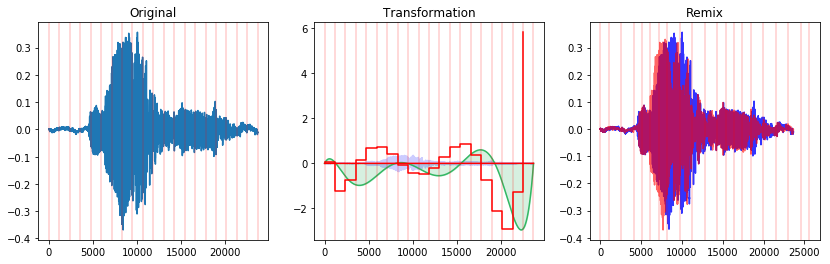

In [42]:
time_transform(y, Gs[2]["G"], 20, 1, visualize=True)